# CS 3110/5110: Data Privacy
## In-Class Exercise, 9/16/2024

In [2]:
# Load the data and libraries
import pandas as pd
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt

def laplace_mech(v, sensitivity, epsilon):
    return v + np.random.laplace(loc=0, scale=sensitivity / epsilon)

def pct_error(orig, priv):
    return np.abs(orig - priv)/orig * 100.0

adult = pd.read_csv('https://github.com/jnear/cs3110-data-privacy/raw/main/homework/adult_with_pii.csv')

In [3]:
# count query
laplace_mech(len(adult[adult['Age'] > 40]),
             sensitivity=1,
             epsilon=1.0)

13443.226959836213

In [4]:
# avg query
# laplace_mech(adult[adult['Age'] > 40]['Age'].mean(),
#              sensitivity=1,
#              epsilon=1.0)

dp_sum = laplace_mech(adult[adult['Age'] > 40]['Age'].sum(),
             sensitivity=1,
             epsilon=1.0)

dp_count = laplace_mech(len(adult[adult['Age'] > 40]),
             sensitivity=1,
             epsilon=1.0)

dp_sum / dp_count

52.01908044121346

In [8]:
# Load the data and libraries
import pandas as pd
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt

adult = pd.read_csv('https://github.com/jnear/cs3110-data-privacy/raw/main/homework/adult_with_pii.csv')

## Question 1

Implement the Laplace mechanism below.

In [9]:
def laplace_mech(v, sensitivity, epsilon):
    # scale of the noise is directly proportional to sensitivity
    # and inversely proportional to epsilon
    noise = np.random.laplace(loc=0, scale=sensitivity/epsilon)
    return v + noise

In [10]:
# TEST CASE for question 1
dist1 = [laplace_mech(50, 1, 1.0) for _ in range(200)]
dist2 = [np.random.laplace(loc=50, scale=1) for _ in range(200)]

assert stats.wasserstein_distance(dist1, dist2) < 1

## Question 2

Write a query to answer the question "how many people in the dataset are over age 30" with differential privacy.



In [5]:
def people_over_30_dp():
    answer = len(adult[adult['Age'] > 30]) # count how many people are over 30
    return laplace_mech(answer, sensitivity=1, epsilon=1.0)

people_over_30_dp()

21990.730384902974

In [6]:
# TEST CASE for question 2
dist1 = [np.random.laplace(loc=21989, scale=1.0) for _ in range(200)]
dist2 = [people_over_30_dp() for _ in range(200)]

assert stats.wasserstein_distance(dist1, dist2) < 1

## Question 3

Consider the following definition of a differencing attack (without differential privacy).

In [15]:
def differencing_attack():
    q1 = adult['Age'].sum()
    q2 = adult[adult['Name'] != 'Karrie Trusslove']['Age'].sum()

    return q1 - q2

print('Differencing attack result:', differencing_attack())

Differencing attack result: 39


Implement a function `dp_differencing_attack` that performs the same attack, but attempts to satisfy differential privacy using the Laplace mechanism. Use the parameters `sensitivity=1` and `epsilon=1.0`.

In [16]:
def dp_differencing_attack():
    q1 = adult['Age'].sum()
    q2 = adult[adult['Name'] != 'Karrie Trusslove']['Age'].sum()
    
    noisy_q1 = laplace_mech(q1, sensitivity=1, epsilon=.5)
    noisy_q2 = laplace_mech(q2, sensitivity=1, epsilon=.5)
    # noise: use laplace_mech twice, with epsilon=.5 each time
    # total privacy budget is epsiolon=1.0

    # I'm returning the difference between two noisy values,
    # which satisfies differential privacy by post-processing
    return noisy_q1 - noisy_q2

print('DP Differencing attack result:', dp_differencing_attack())
# adversary's job: guess whether Karrie was in the dataset or not
# amounts to: was the answer 0 or 39
# this noisy answer lets the adversary take a pretty good guess

DP Differencing attack result: 32.209264593431726


In [17]:
# TEST CASE for question 1
dp_results = [dp_differencing_attack() for _ in range(100)]
spec = [np.random.laplace(loc=39, scale=1) for _ in range(100)]
assert stats.wasserstein_distance(dp_results, spec) < 2

## Question 4

What is the *sensitivity* of the `differencing_attack` query defined above, and why?

The query returns:
- 0 if my target is not in the dataset
- the target's age, if the target is in the dataset

The sensitivity is the worst-case difference between the minimum and maximum possible outputs of the query, when I add or remove a person.

Since these are human ages, 120 is a decent upper bound.


## Question 5

Implement a corrected version of `dp_differencing_attack` that uses the correct sensitivity and thus correctly satisfies differential privacy.

In [18]:
def dp_differencing_attack_corrected():
    q1 = adult['Age'].sum()
    q2 = adult[adult['Name'] != 'Karrie Trusslove']['Age'].sum()
    
    # ---------
    # bug in test case so we changed epsilon to e=2 and sensitivity to 125
    # ---------
    noisy_q1 = laplace_mech(q1, sensitivity=125, epsilon=1)
    noisy_q2 = laplace_mech(q2, sensitivity=125, epsilon=1)
    # sensitivity: the sensitivity of q1 is 125, becasue nobody can be older than 125 years
    # the sensitivity of q2 is 125 for the same reason

    # noise: use laplace_mech twice, with epsilon=.5 each time
    # total privacy budget is epsiolon=2.0

    # I'm returning the difference between two noisy values,
    # which satisfies differential privacy by post-processing
    return noisy_q1 - noisy_q2

print('DP Differencing attack result:', dp_differencing_attack_corrected())

DP Differencing attack result: -2.4631069409660995


In [19]:
# TEST CASE for question 3
dp_results = [dp_differencing_attack_corrected() for _ in range(100)]
spec = [np.random.laplace(loc=39, scale=125/2.0) for _ in range(100)]
assert stats.wasserstein_distance(dp_results, spec) < 200
assert stats.wasserstein_distance(dp_results, spec) > 50

## Question 6

Write a function `dp_mean_age` that calculates the mean age of members of the dataset.

In [20]:
def mean_age():
    return adult['Age'].mean()

mean_age()

38.58164675532078

In [23]:
def dp_mean_age(epsilon):
    dp_sum = laplace_mech(adult['Age'].sum(),
                          sensitivity=125,
                          epsilon=epsilon/2)
    
    dp_count = laplace_mech(len(adult['Age']),
                            sensitivity=1,
                            epsilon=epsilon/2)
    
    return dp_sum / dp_count

In [28]:
# TEST CASE for question 1
results = [dp_mean_age(1) for _ in range(100)]
assert np.abs(np.mean(results) - mean_age()) < 0.1

## Question 7

Write a function `dp_age_sum_clipping` that uses clipping to bound the sensitivity of the sum of ages.

In [29]:
def dp_age_sum_clipping(epsilon, b):
    clipped_ages = adult['Age'].clip(upper=b)
    clipped_sum = clipped_ages.sum()
    dp_sum = laplace_mech(clipped_sum, sensitivity=b, epsilon=epsilon)
    return dp_sum

dp_age_sum_clipping(1.0, 100)

1256109.134655737

In [30]:
# TEST CASE for question 2
results = [dp_age_sum_clipping(1.0, 100) for _ in range(10)]
assert np.abs(np.mean(results) - adult['Age'].sum()) < 100

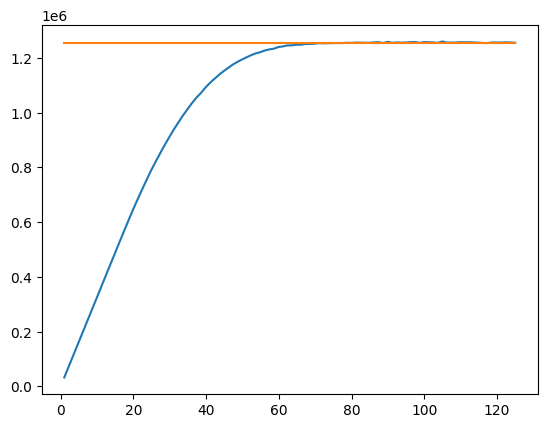

In [32]:
bs = np.linspace(1, 125, 100)
results = [dp_age_sum_clipping(0.1, b) for b in bs]
plt.plot(bs, results);

baseline = [adult['Age'].sum() for b in bs]
plt.plot(bs, baseline);